## 1. Mount Drive and Read Data

In [1]:
# Mount google drive
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
os.chdir('/content/drive/MyDrive/BT4221 Project/Processing   Model /Data')

In [3]:
!pwd

/content/drive/.shortcut-targets-by-id/1tBdSji21KgPglmR793LZtaDQOEIckCP4/BT4221 Project/Processing   Model /Data


In [4]:
train_dir = '/content/drive/My Drive/Data/train'
test_dir = '/content/drive/My Drive/Data/test'

In [5]:
print("Train set:\n========================================")
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
num_covid19 = len(os.listdir(os.path.join(train_dir, 'COVID19')))
print(f"PNEUMONIA={num_pneumonia}")
print(f"NORMAL={num_normal}")
print(f"COVID19={num_covid19}")


print("Test set:\n========================================")
num_pneumonia_test = len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))
num_normal_test = len(os.listdir(os.path.join(test_dir, 'NORMAL')))
num_covid19_test = len(os.listdir(os.path.join(test_dir, 'COVID19')))
print(f"PNEUMONIA={num_pneumonia_test}")
print(f"NORMAL={num_normal_test}")
print(f"COVID19={num_covid19_test}")

Train set:
PNEUMONIA=3418
NORMAL=1266
COVID19=1349
Test set:
PNEUMONIA=855
NORMAL=317
COVID19=116


## 2. Import Libraries

In [6]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import seaborn as sns
import tensorflow

from keras import optimizers
from keras.applications import xception
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Flatten, Activation, Dropout, GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from numpy.random import seed

%matplotlib inline

# Set seed
seed(1)
tensorflow.random.set_seed(2)

## 3. Image Pre-processing

In [7]:
img_size = 299

In [8]:
# Image Preprocessing to perform standardization
train_image_datagen = ImageDataGenerator(rescale=1./299)

train_datagen = train_image_datagen.flow_from_directory(train_dir, 
                                                        batch_size=32, 
                                                        shuffle=True, 
                                                        class_mode='categorical', 
                                                        target_size=(img_size, img_size))

test_image_datagen = ImageDataGenerator(rescale=1./299)

test_datagen = test_image_datagen.flow_from_directory(test_dir, 
                                                      batch_size=16, 
                                                      shuffle=True, 
                                                      class_mode='categorical', 
                                                      target_size=(img_size, img_size))

Found 6033 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


In [9]:
# Compute class weights
print(train_datagen.class_indices)

weight_for_covid19 = num_covid19 / (num_normal + num_pneumonia + num_covid19)
weight_for_normal = num_normal / (num_normal + num_pneumonia + num_covid19)
weight_for_pneumonia = num_pneumonia / (num_normal + num_pneumonia + num_covid19)

class_weight = {0: weight_for_covid19, 1: weight_for_normal, 2: weight_for_pneumonia}

print(f"Weight for class 0 (Covid19): {weight_for_covid19:.2f}")
print(f"Weight for class 1 (Normal): {weight_for_normal:.2f}")
print(f"Weight for class 2 (Pneumonia): {weight_for_pneumonia:.2f}")

{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}
Weight for class 0 (Covid19): 0.22
Weight for class 1 (Normal): 0.21
Weight for class 2 (Pneumonia): 0.57


## 4. Running of Model

## 4.1 Base Model - XCeption

In [10]:
base_model = xception.Xception(weights='imagenet', 
                               include_top=False, 
                               input_shape=(img_size, img_size, 3))

for layer in base_model.layers:
    layer.trainable = False
    
base_model.summary()

83697664/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________

## 4.2.1 Variation 0: 0 Dropout Layers

### Old
- Training Accuracy: 100%
- Testing Accuracy: 96.12%

> x = Dense(1024, activation="relu")(x)

> x = Dense(512, activation="relu")(x)

> x = Dense(256, activation="relu")(x)

> x = Dense(64, activation="relu")(x)

In [ ]:
# Adding custom layers 
x = base_model.output
x = Flatten()(x)

x = Dense(1024, activation="relu")(x)
x = Dense(512, activation="relu")(x)
x = Dense(256, activation="relu")(x)
x = Dense(64, activation="relu")(x)

output = Dense(3, activation="softmax")(x) # 3 classes
model = Model(inputs = base_model.input, outputs = output)

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# Callbacks
checkpoint = ModelCheckpoint("model.h5", monitor='val_accuracy', mode='auto', verbose=1, save_best_only=True)

# Running of Model
history = model.fit(train_datagen,
                    validation_data = test_datagen, 
                    class_weight = class_weight,
                    epochs = 20,
                    callbacks = [checkpoint],
                    verbose = 1
          )

Epoch 1/20
189/189 [==============================] - 1896s 10s/step - loss: 0.3614 - accuracy: 0.8891 - val_loss: 0.2158 - val_accuracy: 0.9394

Epoch 00001: val_accuracy improved from -inf to 0.93944, saving model to model.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
189/189 [==============================] - 246s 1s/step - loss: 0.0425 - accuracy: 0.9516 - val_loss: 0.1425 - val_accuracy: 0.9433

Epoch 00002: val_accuracy improved from 0.93944 to 0.94332, saving model to model.h5
Epoch 3/20
189/189 [==============================] - 247s 1s/step - loss: 0.0232 - accuracy: 0.9707 - val_loss: 0.1234 - val_accuracy: 0.9651

Epoch 00003: val_accuracy improved from 0.94332 to 0.96506, saving model to model.h5
Epoch 4/20
189/189 [==============================] - 247s 1s/step - loss: 0.0187 - accuracy: 0.9756 - val_loss: 0.1231 - val_accuracy: 0.9557

Epoch 00004: val_accuracy did not improve from 0.96506
Epoch 5/20
189/189 [==============================] - 230s 1s/step - loss: 0.0189 - accuracy: 0.9765 - val_loss: 0.1453 - val_accuracy: 0.9433

Epoch 00005: val_accuracy did not improve from 0.96506
Epoch 6/20
189/189 [==============================] - 234s 1s/step - loss: 0.0188 - accuracy: 0.9780 - val_loss: 0.1701 - val_accuracy: 0.9511



Model Evaluation

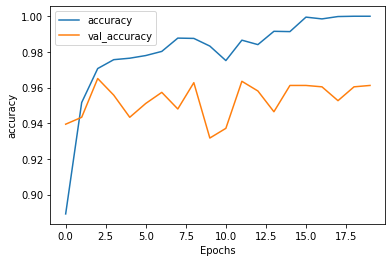

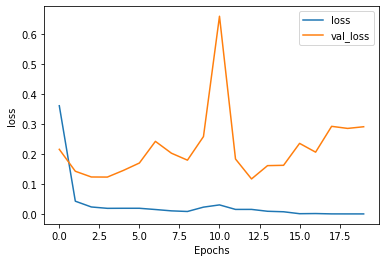

In [ ]:
# Print Graphs (training vs testing)
def plotting(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.ylabel(string)
    plt.xlabel("Epochs")
    plt.legend([string, "val_"+string])
    plt.show()

plotting(history, "accuracy")
plotting(history, "loss")

In [ ]:
# Get Accuracy Rate of Model (training and testing)
scores = model.evaluate(test_datagen)
print(f"Test Accuracy: {scores[1] * 100:.2f}%")

scores = model.evaluate(train_datagen)
print(f"Train Accuracy: {scores[1] * 100:.2f}%")

81/81 [==============================] - 42s 520ms/step - loss: 0.2912 - accuracy: 0.9612
Test Accuracy: 96.12%
189/189 [==============================] - 190s 1s/step - loss: 1.4660e-05 - accuracy: 1.0000
Train Accuracy: 100.00%


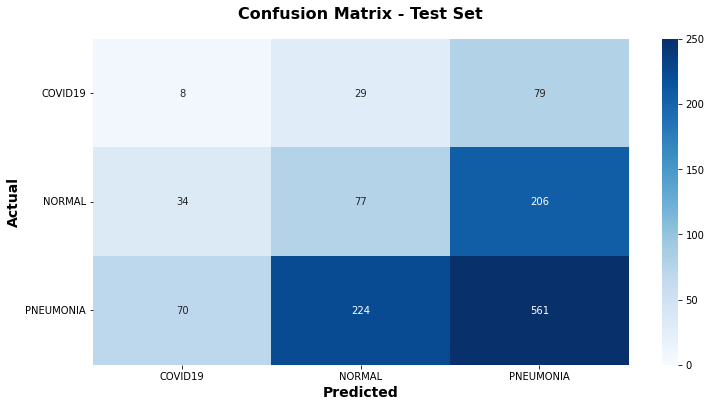

In [ ]:
# Print Confusion Matrix
classes = ['COVID19', 'NORMAL', 'PNEUMONIA']

pred_class = model.predict(test_datagen)
predictions = np.array(list(map(lambda x: np.argmax(x), pred_class)))

y_true= test_datagen.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index=classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

### New (After consult with Prof)
- Training Accuracy: 100%
- Testing Accuracy: 95.96%

In [ ]:
# Adding custom layers 
x = base_model.output
x = Flatten()(x)

x = Dense(256, activation="relu")(x)
x = Dense(256, activation="relu")(x)
x = Dense(256, activation="relu")(x)
x = Dense(256, activation="relu")(x)

output = Dense(3, activation="softmax")(x) # 3 classes
model = Model(inputs = base_model.input, outputs = output)

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# Callbacks
checkpoint = ModelCheckpoint("xception_main.h5", monitor='val_accuracy', mode='auto', verbose=1, save_best_only=True)

# Running of Model
history = model.fit(train_datagen,
                    validation_data = test_datagen, 
                    class_weight = class_weight,
                    epochs = 25,
                    callbacks = [checkpoint],
                    verbose = 1
          )

Epoch 1/25
189/189 [==============================] - 5281s 28s/step - loss: 0.2193 - accuracy: 0.8904 - val_loss: 0.1662 - val_accuracy: 0.9464

Epoch 00001: val_accuracy improved from -inf to 0.94643, saving model to xception_main.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/25
189/189 [==============================] - 226s 1s/step - loss: 0.0414 - accuracy: 0.9581 - val_loss: 0.1495 - val_accuracy: 0.9425

Epoch 00002: val_accuracy did not improve from 0.94643
Epoch 3/25
189/189 [==============================] - 221s 1s/step - loss: 0.0361 - accuracy: 0.9617 - val_loss: 0.1438 - val_accuracy: 0.9565

Epoch 00003: val_accuracy improved from 0.94643 to 0.95652, saving model to xception_main.h5
Epoch 4/25
189/189 [==============================] - 220s 1s/step - loss: 0.0223 - accuracy: 0.9723 - val_loss: 0.1326 - val_accuracy: 0.9612

Epoch 00004: val_accuracy improved from 0.95652 to 0.96118, saving model to xception_main.h5
Epoch 5/25
189/189 [==============================] - 225s 1s/step - loss: 0.0188 - accuracy: 0.9783 - val_loss: 0.1262 - val_accuracy: 0.9604

Epoch 00005: val_accuracy did not improve from 0.96118
Epoch 6/25
189/189 [==============================] - 225s 1s/step - loss: 0.0186 - accuracy: 0.9775 - val_loss: 0.1662 - val_ac

Model Evaluation

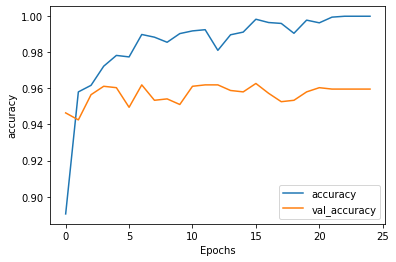

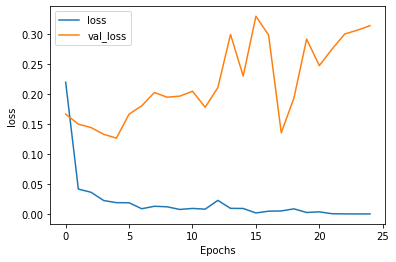

In [ ]:
# Print Graphs (training vs testing)
def plotting(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.ylabel(string)
    plt.xlabel("Epochs")
    plt.legend([string, "val_"+string])
    plt.show()

plotting(history, "accuracy")
plotting(history, "loss")

In [ ]:
# Get Accuracy Rate of Model (training and testing)
scores = model.evaluate(test_datagen)
print(f"Test Accuracy: {scores[1] * 100:.2f}%")

scores = model.evaluate(train_datagen)
print(f"Train Accuracy: {scores[1] * 100:.2f}%")

81/81 [==============================] - 41s 502ms/step - loss: 0.3135 - accuracy: 0.9596
Test Accuracy: 95.96%
189/189 [==============================] - 183s 966ms/step - loss: 1.6375e-05 - accuracy: 1.0000
Train Accuracy: 100.00%


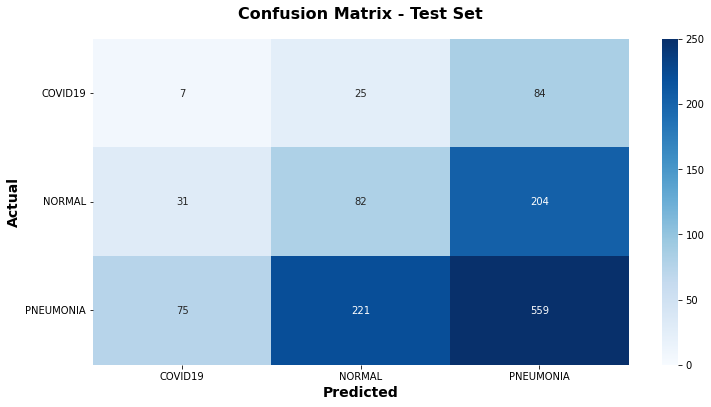

In [ ]:
# Print Confusion Matrix
classes = ['COVID19', 'NORMAL', 'PNEUMONIA']

pred_class = model.predict(test_datagen)
predictions = np.array(list(map(lambda x: np.argmax(x), pred_class)))

y_true= test_datagen.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index=classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

## 4.2.2 Variation 1: 1 Dropout Layer


### Old
- Training Accuracy: 99.62%
- Testing Accuracy: 96.27%

> x = Dense(1024, activation="relu")(x)

> x = Dropout(0.3)(x)

> x = Dense(512, activation="relu")(x)

> x = Dense(256, activation="relu")(x)

> x = Dense(64, activation="relu")(x)

In [ ]:
# Adding custom layers 
x = base_model.output
x = Flatten()(x)

x = Dense(1024, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(512, activation="relu")(x)
x = Dense(256, activation="relu")(x)
x = Dense(64, activation="relu")(x)

output = Dense(3, activation="softmax")(x) # 3 classes
model1 = Model(inputs = base_model.input, outputs = output)

model1.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# Callbacks
checkpoint = ModelCheckpoint("model1.h5", monitor='val_accuracy', mode='auto', verbose=1, save_best_only=True)

# Running of Model
history = model1.fit(train_datagen,
                    validation_data = test_datagen, 
                    class_weight = class_weight,
                    epochs = 20,
                    callbacks = [checkpoint],
                    verbose = 1
          )

Epoch 1/20
189/189 [==============================] - 239s 1s/step - loss: 0.4449 - accuracy: 0.8835 - val_loss: 0.1750 - val_accuracy: 0.9332

Epoch 00001: val_accuracy improved from -inf to 0.93323, saving model to model1.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
189/189 [==============================] - 238s 1s/step - loss: 0.0586 - accuracy: 0.9438 - val_loss: 0.1858 - val_accuracy: 0.9317

Epoch 00002: val_accuracy did not improve from 0.93323
Epoch 3/20
189/189 [==============================] - 231s 1s/step - loss: 0.0405 - accuracy: 0.9571 - val_loss: 0.1169 - val_accuracy: 0.9542

Epoch 00003: val_accuracy improved from 0.93323 to 0.95419, saving model to model1.h5
Epoch 4/20
189/189 [==============================] - 241s 1s/step - loss: 0.0258 - accuracy: 0.9693 - val_loss: 0.1755 - val_accuracy: 0.9309

Epoch 00004: val_accuracy did not improve from 0.95419
Epoch 5/20
189/189 [==============================] - 237s 1s/step - loss: 0.0202 - accuracy: 0.9761 - val_loss: 0.1482 - val_accuracy: 0.9604

Epoch 00005: val_accuracy improved from 0.95419 to 0.96040, saving model to model1.h5
Epoch 6/20
189/189 [==============================] - 243s 1s/step - loss: 0.0259 - accuracy: 0.9722 - val_loss: 0.1925 - val_accuracy: 0.9332

Model Evaluation

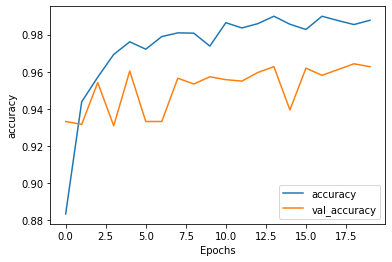

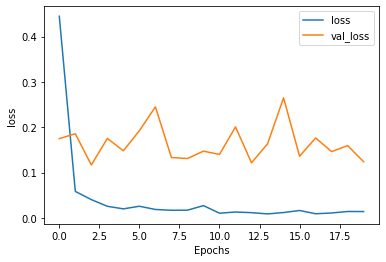

In [ ]:
# Print Graphs (training vs testing)
def plotting(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.ylabel(string)
    plt.xlabel("Epochs")
    plt.legend([string, "val_"+string])
    plt.show()

plotting(history, "accuracy")
plotting(history, "loss")

In [ ]:
# Get Accuracy Rate of Model (training and testing)
scores = model1.evaluate(test_datagen)
print(f"Test Accuracy: {scores[1] * 100:.2f}%")

scores = model1.evaluate(train_datagen)
print(f"Train Accuracy: {scores[1] * 100:.2f}%")

81/81 [==============================] - 43s 524ms/step - loss: 0.1240 - accuracy: 0.9627
Test Accuracy: 96.27%
189/189 [==============================] - 194s 1s/step - loss: 0.0157 - accuracy: 0.9962
Train Accuracy: 99.62%


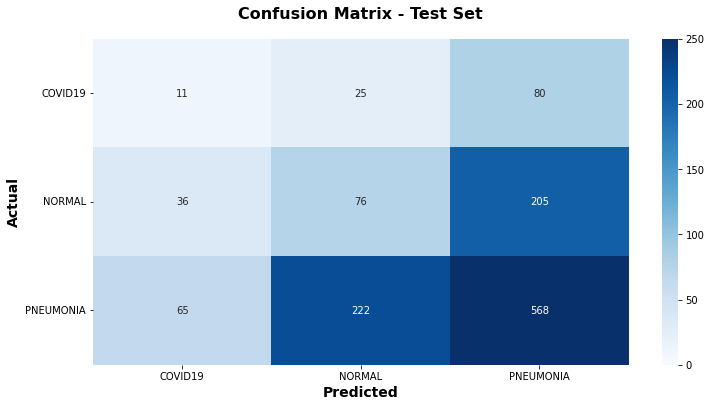

In [ ]:
# Print Confusion Matrix
classes = ['COVID19', 'NORMAL', 'PNEUMONIA']

pred_class = model1.predict(test_datagen)
predictions = np.array(list(map(lambda x: np.argmax(x), pred_class)))

y_true= test_datagen.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index=classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

### New (After consult with Prof)

In [11]:
# Adding custom layers 
x = base_model.output
x = Flatten()(x)

x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = Dense(256, activation="relu")(x)
x = Dense(256, activation="relu")(x)

output = Dense(3, activation="softmax")(x) # 3 classes
model = Model(inputs = base_model.input, outputs = output)

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [12]:
# Callbacks
checkpoint = ModelCheckpoint("xception_1dropout.h5", monitor='val_accuracy', mode='auto', verbose=1, save_best_only=True)

# Running of Model
history = model.fit(train_datagen,
                    validation_data = test_datagen, 
                    class_weight = class_weight,
                    epochs = 25,
                    callbacks = [checkpoint],
                    verbose = 1
          )

Epoch 1/25
189/189 [==============================] - 1649s 9s/step - loss: 0.2625 - accuracy: 0.8516 - val_loss: 0.2028 - val_accuracy: 0.9262

Epoch 00001: val_accuracy improved from -inf to 0.92624, saving model to xception_1dropout.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/25
189/189 [==============================] - 232s 1s/step - loss: 0.0620 - accuracy: 0.9231 - val_loss: 0.1201 - val_accuracy: 0.9581

Epoch 00002: val_accuracy improved from 0.92624 to 0.95807, saving model to xception_1dropout.h5
Epoch 3/25
189/189 [==============================] - 228s 1s/step - loss: 0.0626 - accuracy: 0.9219 - val_loss: 0.1541 - val_accuracy: 0.9534

Epoch 00003: val_accuracy did not improve from 0.95807
Epoch 4/25
189/189 [==============================] - 224s 1s/step - loss: 0.0523 - accuracy: 0.9365 - val_loss: 0.1197 - val_accuracy: 0.9511

Epoch 00004: val_accuracy did not improve from 0.95807
Epoch 5/25
189/189 [==============================] - 226s 1s/step - loss: 0.0434 - accuracy: 0.9496 - val_loss: 0.1205 - val_accuracy: 0.9596

Epoch 00005: val_accuracy improved from 0.95807 to 0.95963, saving model to xception_1dropout.h5
Epoch 6/25
189/189 [==============================] - 226s 1s/step - loss: 0.0412 - accuracy: 0.9509 - val_loss: 0.1262 

Model Evaluation

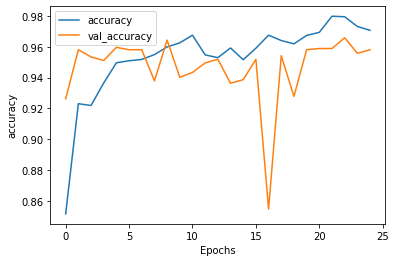

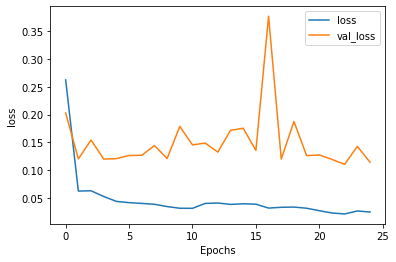

In [13]:
# Print Graphs (training vs testing)
def plotting(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.ylabel(string)
    plt.xlabel("Epochs")
    plt.legend([string, "val_"+string])
    plt.show()

plotting(history, "accuracy")
plotting(history, "loss")

In [14]:
# Get Accuracy Rate of Model (training and testing)
scores = model.evaluate(test_datagen)
print(f"Test Accuracy: {scores[1] * 100:.2f}%")

scores = model.evaluate(train_datagen)
print(f"Train Accuracy: {scores[1] * 100:.2f}%")

81/81 [==============================] - 41s 508ms/step - loss: 0.1141 - accuracy: 0.9581
Test Accuracy: 95.81%
189/189 [==============================] - 186s 981ms/step - loss: 0.0462 - accuracy: 0.9899
Train Accuracy: 98.99%


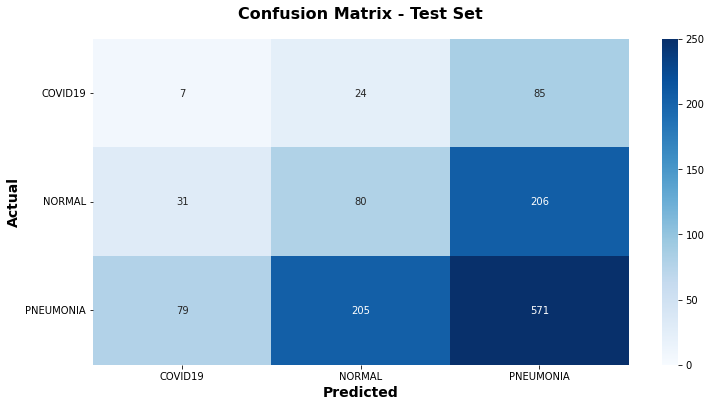

In [15]:
# Print Confusion Matrix
classes = ['COVID19', 'NORMAL', 'PNEUMONIA']

pred_class = model.predict(test_datagen)
predictions = np.array(list(map(lambda x: np.argmax(x), pred_class)))

y_true= test_datagen.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index=classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

## 4.2.3 Variation 2: 2 Dropout Layers
- Training Accuracy: 99.30%
- Testing Accuracy: 96.04%

> x = Dense(1024, activation="relu")(x)

> x = Dropout(0.3)(x)

> x = Dense(512, activation="relu")(x)

> x = Dropout(0.3)(x)

> x = Dense(256, activation="relu")(x)

> x = Dense(64, activation="relu")(x)





In [ ]:
# Adding custom layers 
x = base_model.output
x = Flatten()(x)

x = Dense(1024, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(256, activation="relu")(x)
x = Dense(64, activation="relu")(x)

output = Dense(3, activation="softmax")(x) # 3 classes
model2 = Model(inputs = base_model.input, outputs = output)

model2.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
model2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# Callbacks
checkpoint = ModelCheckpoint("model2.h5", monitor='val_accuracy', mode='auto', verbose=1, save_best_only=True)

# Running of Model
history = model2.fit(train_datagen,
                    validation_data = test_datagen, 
                    class_weight = class_weight,
                    epochs = 20,
                    callbacks = [checkpoint],
                    verbose = 1
          )

Epoch 1/20
189/189 [==============================] - 3750s 20s/step - loss: 0.4510 - accuracy: 0.8642 - val_loss: 0.2435 - val_accuracy: 0.8711

Epoch 00001: val_accuracy improved from -inf to 0.87112, saving model to model2.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
189/189 [==============================] - 251s 1s/step - loss: 0.0602 - accuracy: 0.9317 - val_loss: 0.1330 - val_accuracy: 0.9550

Epoch 00002: val_accuracy improved from 0.87112 to 0.95497, saving model to model2.h5
Epoch 3/20
189/189 [==============================] - 253s 1s/step - loss: 0.0468 - accuracy: 0.9418 - val_loss: 0.1248 - val_accuracy: 0.9519

Epoch 00003: val_accuracy did not improve from 0.95497
Epoch 4/20
189/189 [==============================] - 235s 1s/step - loss: 0.0335 - accuracy: 0.9589 - val_loss: 0.1437 - val_accuracy: 0.9410

Epoch 00004: val_accuracy did not improve from 0.95497
Epoch 5/20
189/189 [==============================] - 236s 1s/step - loss: 0.0372 - accuracy: 0.9594 - val_loss: 0.1450 - val_accuracy: 0.9402

Epoch 00005: val_accuracy did not improve from 0.95497
Epoch 6/20
189/189 [==============================] - 235s 1s/step - loss: 0.0254 - accuracy: 0.9668 - val_loss: 0.1296 - val_accuracy: 0.9651

Epoch 00006: val_accuracy imp

Model Evaluation

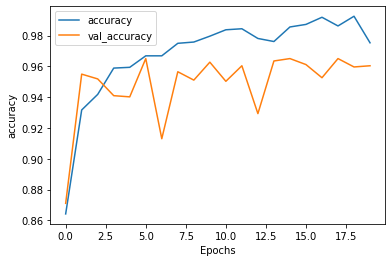

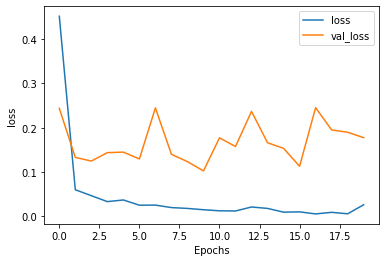

In [ ]:
# Print Graphs (training vs testing)
def plotting(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.ylabel(string)
    plt.xlabel("Epochs")
    plt.legend([string, "val_"+string])
    plt.show()

plotting(history, "accuracy")
plotting(history, "loss")

In [ ]:
# Get Accuracy Rate of Model (training and testing)
scores = model2.evaluate(test_datagen)
print(f"Test Accuracy: {scores[1] * 100:.2f}%")

scores = model2.evaluate(train_datagen)
print(f"Train Accuracy: {scores[1] * 100:.2f}%")

81/81 [==============================] - 42s 513ms/step - loss: 0.1775 - accuracy: 0.9604
Test Accuracy: 96.04%
189/189 [==============================] - 189s 997ms/step - loss: 0.0333 - accuracy: 0.9930
Train Accuracy: 99.30%


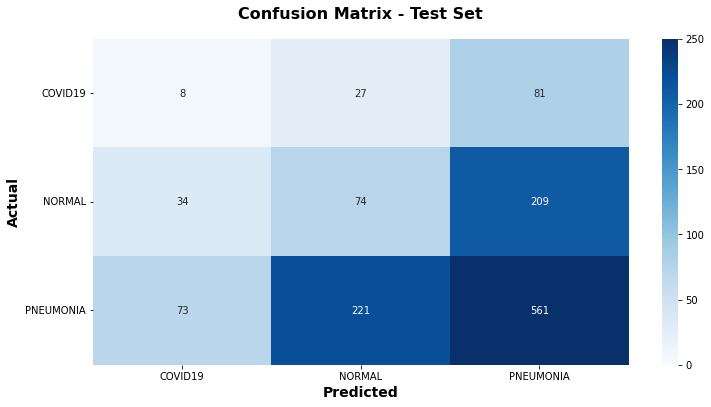

In [ ]:
# Print Confusion Matrix
classes = ['COVID19', 'NORMAL', 'PNEUMONIA']

pred_class = model2.predict(test_datagen)
predictions = np.array(list(map(lambda x: np.argmax(x), pred_class)))

y_true= test_datagen.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index=classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

## 4.2.4 Variation 3: 3 Dropout Layers
- Training Accuracy: 98.48%
- Testing Accuracy: 94.95%

> x = Dense(1024, activation="relu")(x)

> x = Dropout(0.3)(x)

> x = Dense(512, activation="relu")(x)

> x = Dropout(0.3)(x)

> x = Dense(256, activation="relu")(x)

> x = Dropout(0.3)(x)

> x = Dense(64, activation="relu")(x)

In [ ]:
# Adding custom layers 
x = base_model.output
x = Flatten()(x)

x = Dense(1024, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(64, activation="relu")(x)

output = Dense(3, activation="softmax")(x) # 3 classes
model3 = Model(inputs = base_model.input, outputs = output)

model3.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
model3.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# Callbacks
checkpoint = ModelCheckpoint("model3.h5", monitor='val_accuracy', mode='auto', verbose=1, save_best_only=True)

# Running of Model
history = model3.fit(train_datagen,
                    validation_data = test_datagen, 
                    class_weight = class_weight,
                    epochs = 20,
                    callbacks = [checkpoint],
                    verbose = 1
          )

Epoch 1/20
189/189 [==============================] - 249s 1s/step - loss: 0.5805 - accuracy: 0.8556 - val_loss: 0.2118 - val_accuracy: 0.9030

Epoch 00001: val_accuracy improved from -inf to 0.90295, saving model to model3.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
189/189 [==============================] - 247s 1s/step - loss: 0.0746 - accuracy: 0.9276 - val_loss: 0.1425 - val_accuracy: 0.9488

Epoch 00002: val_accuracy improved from 0.90295 to 0.94876, saving model to model3.h5
Epoch 3/20
189/189 [==============================] - 251s 1s/step - loss: 0.0599 - accuracy: 0.9340 - val_loss: 0.1624 - val_accuracy: 0.9542

Epoch 00003: val_accuracy improved from 0.94876 to 0.95419, saving model to model3.h5
Epoch 4/20
189/189 [==============================] - 254s 1s/step - loss: 0.0516 - accuracy: 0.9460 - val_loss: 0.1321 - val_accuracy: 0.9526

Epoch 00004: val_accuracy did not improve from 0.95419
Epoch 5/20
189/189 [==============================] - 243s 1s/step - loss: 0.0439 - accuracy: 0.9499 - val_loss: 0.1097 - val_accuracy: 0.9589

Epoch 00005: val_accuracy improved from 0.95419 to 0.95885, saving model to model3.h5
Epoch 6/20
189/189 [==============================] - 246s 1s/step - loss: 0.0335 - accuracy: 0.9589 - val_loss

Model Evaluation

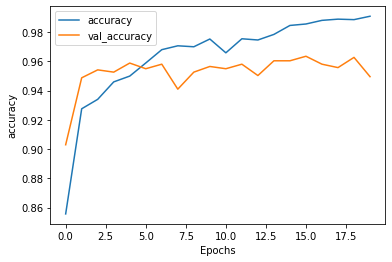

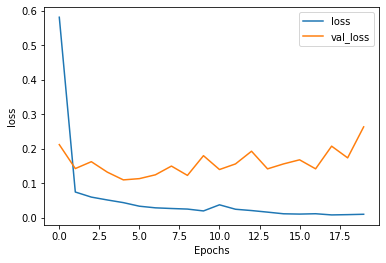

In [ ]:
# Print Graphs (training vs testing)
def plotting(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.ylabel(string)
    plt.xlabel("Epochs")
    plt.legend([string, "val_"+string])
    plt.show()

plotting(history, "accuracy")
plotting(history, "loss")

In [ ]:
# Get Accuracy Rate of Model (training and testing)
scores = model3.evaluate(test_datagen)
print(f"Test Accuracy: {scores[1] * 100:.2f}%")

scores = model3.evaluate(train_datagen)
print(f"Train Accuracy: {scores[1] * 100:.2f}%")

81/81 [==============================] - 51s 618ms/step - loss: 0.2632 - accuracy: 0.9495
Test Accuracy: 94.95%
189/189 [==============================] - 193s 1s/step - loss: 0.0683 - accuracy: 0.9848
Train Accuracy: 98.48%


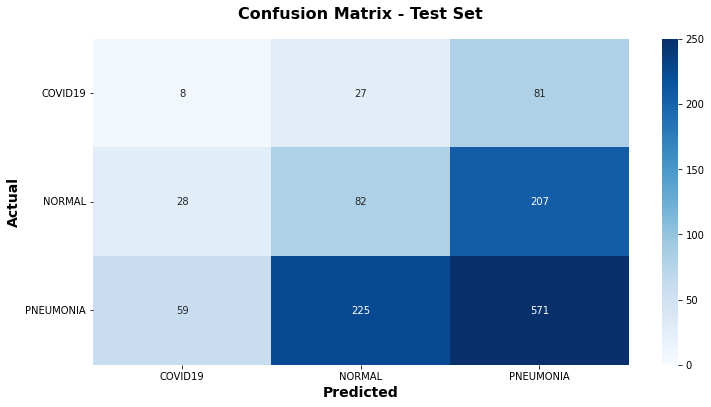

In [ ]:
# Print Confusion Matrix
classes = ['COVID19', 'NORMAL', 'PNEUMONIA']

pred_class = model3.predict(test_datagen)
predictions = np.array(list(map(lambda x: np.argmax(x), pred_class)))

y_true= test_datagen.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index=classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

## 4.2.5 Variation 4: 4 Dropout Layers
- Training Accuracy: 98.46%
- Testing Accuracy: 94.95%

> x = Dense(1024, activation="relu")(x)

> x = Dropout(0.3)(x)

> x = Dense(512, activation="relu")(x)

> x = Dropout(0.3)(x)

> x = Dense(256, activation="relu")(x)

> x = Dropout(0.3)(x)

> x = Dense(64, activation="relu")(x)

> x = Dropout(0.3)(x)

In [ ]:
# Adding custom layers 
x = base_model.output
x = Flatten()(x)

x = Dense(1024, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.3)(x)

output = Dense(3, activation="softmax")(x) # 3 classes
model4 = Model(inputs = base_model.input, outputs = output)

model4.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
model4.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# Callbacks
checkpoint = ModelCheckpoint("model4.h5", monitor='val_accuracy', mode='auto', verbose=1, save_best_only=True)

# Running of Model
history = model4.fit(train_datagen,
                    validation_data = test_datagen, 
                    class_weight = class_weight,
                    epochs = 20,
                    callbacks = [checkpoint],
                    verbose = 1
          )

Epoch 1/20
189/189 [==============================] - 1750s 9s/step - loss: 0.7212 - accuracy: 0.8178 - val_loss: 0.2855 - val_accuracy: 0.8672

Epoch 00001: val_accuracy improved from -inf to 0.86724, saving model to model4.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
189/189 [==============================] - 252s 1s/step - loss: 0.0990 - accuracy: 0.8919 - val_loss: 0.1751 - val_accuracy: 0.9425

Epoch 00002: val_accuracy improved from 0.86724 to 0.94255, saving model to model4.h5
Epoch 3/20
189/189 [==============================] - 254s 1s/step - loss: 0.0771 - accuracy: 0.9141 - val_loss: 0.1541 - val_accuracy: 0.9472

Epoch 00003: val_accuracy improved from 0.94255 to 0.94720, saving model to model4.h5
Epoch 4/20
189/189 [==============================] - 250s 1s/step - loss: 0.0598 - accuracy: 0.9327 - val_loss: 0.1260 - val_accuracy: 0.9488

Epoch 00004: val_accuracy improved from 0.94720 to 0.94876, saving model to model4.h5
Epoch 5/20
189/189 [==============================] - 261s 1s/step - loss: 0.0411 - accuracy: 0.9511 - val_loss: 0.1060 - val_accuracy: 0.9620

Epoch 00005: val_accuracy improved from 0.94876 to 0.96196, saving model to model4.h5
Epoch 6/20
189/189 [==============================] - 258s 1s/step - loss: 0.051

Model Evaluation

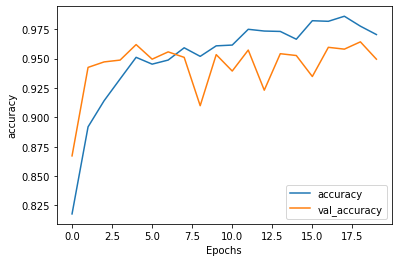

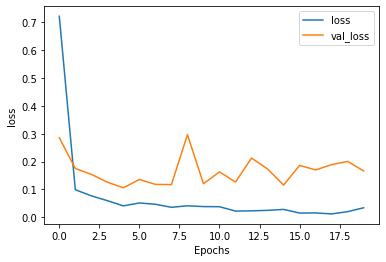

In [ ]:
# Print Graphs (training vs testing)
def plotting(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.ylabel(string)
    plt.xlabel("Epochs")
    plt.legend([string, "val_"+string])
    plt.show()

plotting(history, "accuracy")
plotting(history, "loss")

In [ ]:
# Get Accuracy Rate of Model (training and testing)
scores = model4.evaluate(test_datagen)
print(f"Test Accuracy: {scores[1] * 100:.2f}%")

scores = model4.evaluate(train_datagen)
print(f"Train Accuracy: {scores[1] * 100:.2f}%")

81/81 [==============================] - 42s 511ms/step - loss: 0.1664 - accuracy: 0.9495
Test Accuracy: 94.95%
189/189 [==============================] - 187s 985ms/step - loss: 0.0420 - accuracy: 0.9846
Train Accuracy: 98.46%


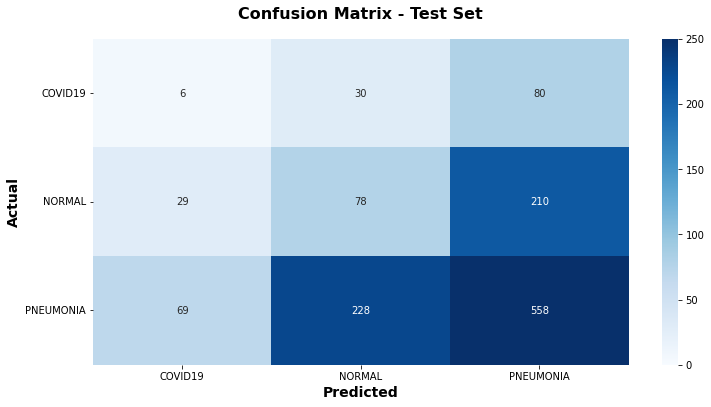

In [ ]:
# Print Confusion Matrix
classes = ['COVID19', 'NORMAL', 'PNEUMONIA']

pred_class = model4.predict(test_datagen)
predictions = np.array(list(map(lambda x: np.argmax(x), pred_class)))

y_true= test_datagen.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index=classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);